## STORDAT.GPR: creates bus data file BDT.DAT for use by NFXP.GPR

###  INITIALIZE VARIABLES

   key variables saved:

   n:      fixed point dimension (positive integer)
   
   
   omax:   positive real, upper bound on odometer reading on buses
   
   
   modnum: 8x1 vector whose components are
   
   
       modnum[1]: index of type of cost function used (see function.g)
	   modnum[2]: number of unknown parameters in cost function
	   modnum[3]: 1 for partial likelihood, 2 for full likelihood
	   modnum[4]: 0 if discount factor (bet) fixed, 1 if bet is estimated
	   modnum[5]: maximum discretized monthly mileage (computed in 
		      stordat.gpr). Since there is possibility of 0
		      mileage, the dimension of the probability vector p
		      giving monthly mileage is modnum[5]+1
       modnum[6]: currently unused 
	   modnum[7]: 1 to include lagged mileage in model, 0 otherwise

   ogrid:  nx1 vector defining discretization of odometer state on [0,omax]
   
   
   p:      modnum[5]+1 x 1 vector with discretizied mileage probabilities

		p{o_{t+1}=o_t+i|o_t}=p[i], i=0,...,modnum[5]   */

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from goto import with_goto
import os

In [2]:
plt.style.use('ggplot')

In [3]:
from ipynb.fs.full.function import sm
from ipynb.fs.full.function import sm_
from ipynb.fs.full.function import smu

### Add it to the top

In [5]:
print('STORDAT.GPR: creates bus data file BDT.DAT for use by NFXP.GPR \nVersion 8, October, 2000. By John Rust, Yale University \nThis program prepares bus data from the Madison Metro Bus Co\nfor estimation using the nested fixed point algorithm. The program\nreads the raw bus data files (*.FMT) producing an output file BDT.DAT\nwith fixed point dimension n selected by the user. BDT.DAT consists\nof either 3 or 4 columns of binary data, depending on the options\nchosen below. The second column, dtx, is the state variable x(t)\nwhich specifies a mileage range which contains true odometer of the bus\nreading during month t. The first column, dtc, is the dependent\nvariable i(t) which equals 1 if the bus engine was replaced in month t\nwhen state of the bus was x(t), and 0 otherwise. The third column, mil,\nis the monthly mileage variable mil=[x(t)-x(t-1)] giving the change\nin the bus odometer reading during month t. You also have the option\nto include the lagged dependent variable i(t-1) in the data set. This\nallows you to conduct a specification test of the assumption that \nunobserved state variables are serially independent given {x(t)}.')

STORDAT.GPR: creates bus data file BDT.DAT for use by NFXP.GPR 
Version 8, October, 2000. By John Rust, Yale University 
This program prepares bus data from the Madison Metro Bus Co
for estimation using the nested fixed point algorithm. The program
reads the raw bus data files (*.FMT) producing an output file BDT.DAT
with fixed point dimension n selected by the user. BDT.DAT consists
of either 3 or 4 columns of binary data, depending on the options
chosen below. The second column, dtx, is the state variable x(t)
which specifies a mileage range which contains true odometer of the bus
reading during month t. The first column, dtc, is the dependent
variable i(t) which equals 1 if the bus engine was replaced in month t
when state of the bus was x(t), and 0 otherwise. The third column, mil,
is the monthly mileage variable mil=[x(t)-x(t-1)] giving the change
in the bus odometer reading during month t. You also have the option
to include the lagged dependent variable i(t-1) in the data set. T

In [6]:
@with_goto
def stordat():
    
    global lfe,rws,cstp,modnum,dt,ov1,ov2,nr,m,dtc,mil,n,p,omax,ogrid
    global strng,rt,nt,rc,nc,ll,loop,milecnt,dtx,npk,lp,g,bdt,grf
    
    
    lfe = 0
    rws = 0
    cstp = 0
    modnum = np.zeros((7,1))
    
    #SELECT FIXED POINT DIMENSION AND SIZE OF MILEAGE CELLS
    
    n = int(input("enter desired fixed point dimension 'n' "))
    omax = int(input("enter upper bound odometer value (recommend 450,000)"))
    print("implied size of discrete mileage range={}".format(omax/n))
    modnum[6] = int(input("include lagged replacement choice i(t-1) in data set? (1=yes, 0=no)"))
    
    rt = np.zeros((n,1))
    nt = np.zeros((n,1))
    rc = np.zeros((n,1))
    nc = np.zeros((n,1))
    ll = 0
    loop = 1
    milecnt = np.zeros((n,1))
    
    #SELECT BUS GROUPS TO BE INCLUDED IN ESTIMATION SAMPLE
    
    print("enter bus groups to be included in BDT.DAT (1=include, 0=leave out)")
    
    label .start
    
    if loop == 1:
        loop = 2
        swj = int(input("Bus group 1: 1983 Grumman model 870 buses (15 buses total)\n(1=include, 0=leave out)"))
        
        if swj == 1:
            dt = open("g870.asc").read().split()
            for i in range(0,len(dt)):
                dt[i] = int(dt[i])
            dt = np.array(dt)
            dt = dt.reshape((15,np.shape(dt)[0]//15)).T
            goto .dtstor
        else:
            goto .start
    
    
    elif loop == 2:
        loop = 3
        swj = int(input("Bus group 2: 1981 Chance RT-50 buses (4 buses total)\n(1=include, 0=leave out)"))
        
        if swj == 1:
            dt = open("rt50.asc").read().split()
            for i in range(0,len(dt)):
                dt[i] = int(dt[i])
            dt = np.array(dt)
            dt = dt.reshape((4,np.shape(dt)[0]//4)).T
            goto .dtstor
        else:
            goto .start
    
    
    elif loop == 3:
        loop = 4
        swj = int(input("Bus group 3: 1979 GMC model t8h203 buses (48 buses total)\n(1=include, 0=leave out)"))
        
        if swj == 1:
            dt = open("t8h203.asc").read().split()
            for i in range(0,len(dt)):
                dt[i] = int(dt[i])
            dt = np.array(dt)
            dt = dt.reshape((48,np.shape(dt)[0]//48)).T    
            goto .dtstor
        else:
            goto .start
    
    
    elif loop == 4:
        loop = 5
        swj = int(input("Bus group 4: 1975 GMC model a5308 buses (37 buses total)\n(1=include, 0=leave out)"))
        
        if swj == 1:
            dt = open("a530875.asc").read().split()
            for i in range(0,len(dt)):
                dt[i] = int(dt[i])
            dt = np.array(dt)
            dt = dt.reshape((37,np.shape(dt)[0]//37)).T
            goto .dtstor
        else:
            goto .start
    
    
    elif loop == 5:
        loop = 6
        swj = int(input("Bus group 5: 1972 GMC model a5308 buses (18 buses total)\n(1=include, 0=leave out)"))
        
        if swj == 1:
            dt = open("a530872.asc").read().split()
            for i in range(0,len(dt)):
                dt[i] = int(dt[i])
            dt = np.array(dt)
            dt = dt.reshape((18,np.shape(dt)[0]//18)).T 
            goto .dtstor
        else:
            goto .start
            
    
    elif loop == 6:
        loop = 7
        swj = int(input("Bus group 6: 1972 GMC model a4523 buses (18 buses total)\n(1=include, 0=leave out)"))
        
        if swj == 1:
            dt = open("a452372.asc").read().split()
            for i in range(0,len(dt)):
                dt[i] = int(dt[i])
            dt = np.array(dt)
            dt = dt.reshape((18,np.shape(dt)[0]//18)).T 
            goto .dtstor
        else:
            goto .start
    

    elif loop == 7:
        loop = 8
        swj = int(input("Bus group 7: 1974 GMC model a4523 buses (10 buses total)\n(1=include, 0=leave out)"))
        
        if swj == 1:
            dt = open("a452374.asc").read().split()
            for i in range(0,len(dt)):
                dt[i] = int(dt[i])
            dt = np.array(dt)
            dt = dt.reshape((10,np.shape(dt)[0]//10)).T     
            goto .dtstor
        else:
            goto .start
    
    
    elif loop == 8:
        loop = 9
        swj = int(input("Bus group 8: 1974 GMC model a5308 buses (12 buses total)\n(1=include, 0=leave out)"))
        
        if swj == 1:
            dt = open("a530874.asc").read().split()
            for i in range(0,len(dt)):
                dt[i] = int(dt[i])
            dt = np.array(dt)
            dt = dt.reshape((12,np.shape(dt)[0]//12)).T 
            goto .dtstor
        else:
            goto.start
    
    else:
        goto .fin
        
    
    #DISCRETIZE CONTINUOUS MILEAGE DATA
    
    label .dtstor
    
    
    ov1 = dt[5,:]
    ov2 = dt[8,:]
    nr = np.shape(dt)[0]
    m = np.shape(dt)[1]
    dtc = smu(b=sm(dt[11:nr,:]>=ov1), s=sm(ov1>0)) + smu(b=sm(dt[11:nr,:]>=ov2), s=sm(ov2>0))
    mil = dt[12:nr,:]-dt[11:nr-1,:]
    
    print("minimum, maximum, mean monthly mileage",min(np.min(mil,axis=0)),max(np.max(mil,axis=0)),np.round(np.mean(np.mean(mil,axis=0))) )
    print("begin discretizing data ... ")
    
    dtx = dt[11:nr,:]+ov1*dtc*(dtc-2)-0.5*ov2*dtc*(dtc-1)
    dtx = np.ceil(n*dtx/omax)
    dtc = np.concatenate([dtc[1:nr-11,:]-dtc[0:nr-12,:],np.zeros((1,m))], axis=0)
    mil = (dtx[1:nr-11,:]-dtx[0:nr-12,:])+dtx[0:nr-12,:]*dtc[0:nr-12,:]
    
    
    
    #COMPUTE NON-PARAMETRIC HAZARD ESTIMATE
    
    for j in range(1,n+1):
        dt = sm_(dtx == j)
        nc[(j-1),0] = np.array([np.sum((np.array([np.sum(dt,axis=0)]).T),axis=0)]).T
        rc[(j-1),0] = np.array([np.sum((np.array([np.sum(dt*dtc,axis=0)]).T),axis=0)]).T
        nt[(j-1),0] = nc[j-1,0] + nt[j-1,0]
        rt[(j-1),0] = rt[j-1,0] + rc[j-1,0]
        
    npk = rt/(nt-sm_(nt==0))
    
    vc = []
    for i in dtx.flatten(order='F'):
        vc.append(int(i)-1)
    
    lp = (1-npk)[vc,:]
    ll = ll + np.array([np.log(lp+(1-2*lp)*np.array([dtc.flatten(order='F')]).T).sum(axis=0)]).T
    
    #DISPLAY ESTIMATED DISCRETIZED MULTINOMIAL MILEAGE DISTRIBUTION
    
    print("minimum, maximum discretized mileage  {}  {}".format(np.min(np.min(mil, axis=0)),np.max(np.max(mil, axis=0)) ))
    
    if np.max(np.max(mil, axis=0)) > modnum[4]:
        
        modnum[4] = np.max(np.max(mil, axis=0))
    
    p = np.zeros((int(modnum[4])+1,1))
    for i in range(0,np.shape(p)[0]):
        p[i] = np.array([np.mean(np.reshape(sm_(mil==i).flatten(order='F'), newshape=(len(sm_(mil==1).flatten(order='F')), 1)),axis=0)]).T   
    
    
    #WRITE DISCRETIZED DATA TO GAUSS DATA FILE bdt.dat
    
    if rws > 0:
        goto .writerow
    
    #if modnum[7] == 0;                              UNNECESSARY PART
    #       create f1=bdt with bdt, 3, 2;
    #else;
    #    create f1=bdt with bdt, 4, 2;
    # endif;
    
    
    label .writerow
    
    if modnum[6] == 0:
        
        len_ = len(np.array(dtc[1:nr-11,:].flatten(order='F')))
        bdt = np.concatenate([np.reshape(np.array(dtc[1:nr-11,:].flatten(order='F')), (len_,1)), np.reshape(np.array(dtx[1:nr-11,:].flatten(order='F')), (len_,1)), np.reshape(np.array(mil.flatten(order='F')), (len_,1)) ], axis=1) 
        rws = len(bdt)
        
    else:
        
        bdt = np.concatenate([dtc[1:nr-11,:], dtx[1:nr-11,:], mil, dtc[0:nr-12,:] ], axis=1)
        rws = len(bdt)
    
    lfe = lfe + rws
    
    
    #PRINT SUMMARY OF ESTIMATED MULTINOMIAL MILEAGE DISTRIBUTION
    
    milecnt[0:np.shape(p)[0]] = milecnt[0:np.shape(p)[0]]+(nr-12)*m*p
    dataf = pd.DataFrame(data=np.concatenate([np.array([np.arange(start=0, stop= modnum[4]+1,step=1)]).T,p,milecnt[0:int(modnum[4])+1]/lfe ],axis=1), columns=["Mileage range", "current estimate", "cumulative estimate"], index=None)
    print(dataf)
    print("total rows written, cumulative, current", lfe, (nr-12)*m)
    
    goto .start
    
    label .fin
    
    #it says closeall here but idk if that's necessary
    p = milecnt[0:int(modnum[4])+1]/lfe
    ogrid = np.array([np.arange(start=0, stop= n,step=1)]).T * omax / (1000*n)
    
    print("STORDAT.GPR successfully created data file bdt")
    print("ready to run SETUP.GPR to set parameters for NFXP algorithm")
    
    #GRAPH NON-PARAMETRIC HAZARD AND NUMBER OF OBSERVATIONS
    
    grf = int(input("Graph non-parametric estimate of replacement hazard? (1=yes,0=no) "))
    
    if grf:
        
        plt.figure(figsize=(12,10))
        plt.plot(ogrid, npk)
        plt.xlabel("Miles Since Last Replacement (000)")
        plt.ylabel("Replacment Probability")
        plt.title("Non-Parametric Hazard")
        plt.xticks(np.arange(min(ogrid), max(ogrid)+1, 20))
        plt.yticks(np.arange(min(npk),max(npk)+0.003,0.01))
        
        
        plt.figure(figsize=(12,10))
        plt.plot(ogrid,nt)
        plt.xlabel("Miles Since Last Replacement (000)")
        plt.ylabel("Number of Observations")
        plt.title("Replacement Observations")
        plt.xticks(np.arange(min(ogrid), max(ogrid)+1, 20))
        plt.yticks(np.arange(min(nt),max(nt)+100,200))
    
    

enter desired fixed point dimension 'n' 3
enter upper bound odometer value (recommend 450,000)450000
implied size of discrete mileage range=150000.0
include lagged replacement choice i(t-1) in data set? (1=yes, 0=no)1
enter bus groups to be included in BDT.DAT (1=include, 0=leave out)
Bus group 1: 1983 Grumman model 870 buses (15 buses total)
(1=include, 0=leave out)1
minimum, maximum, mean monthly mileage 0 6780 4150.0
begin discretizing data ... 
minimum, maximum discretized mileage  0.0  0.0
   Mileage range  current estimate  cumulative estimate
0            0.0               1.0                 15.0
total rows written, cumulative, current 24 360
Bus group 2: 1981 Chance RT-50 buses (4 buses total)
(1=include, 0=leave out)0
Bus group 3: 1979 GMC model t8h203 buses (48 buses total)
(1=include, 0=leave out)0
Bus group 4: 1975 GMC model a5308 buses (37 buses total)
(1=include, 0=leave out)0
Bus group 5: 1972 GMC model a5308 buses (18 buses total)
(1=include, 0=leave out)1
minimum, max

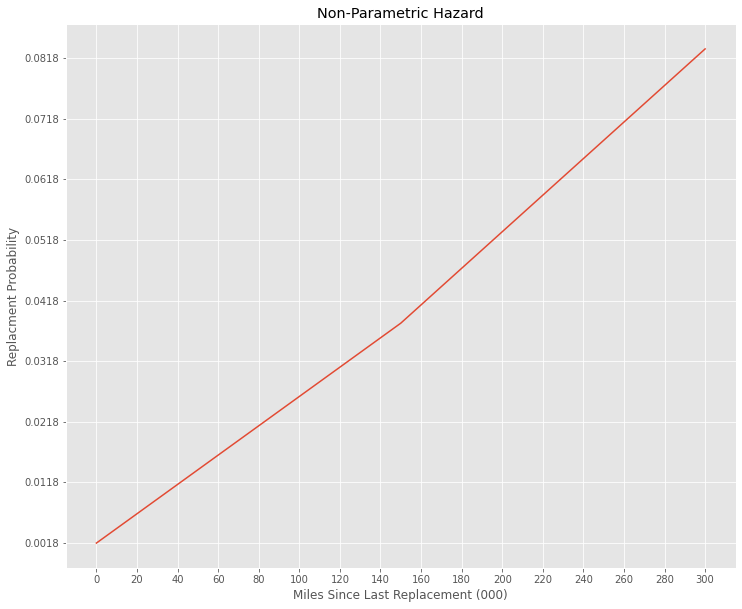

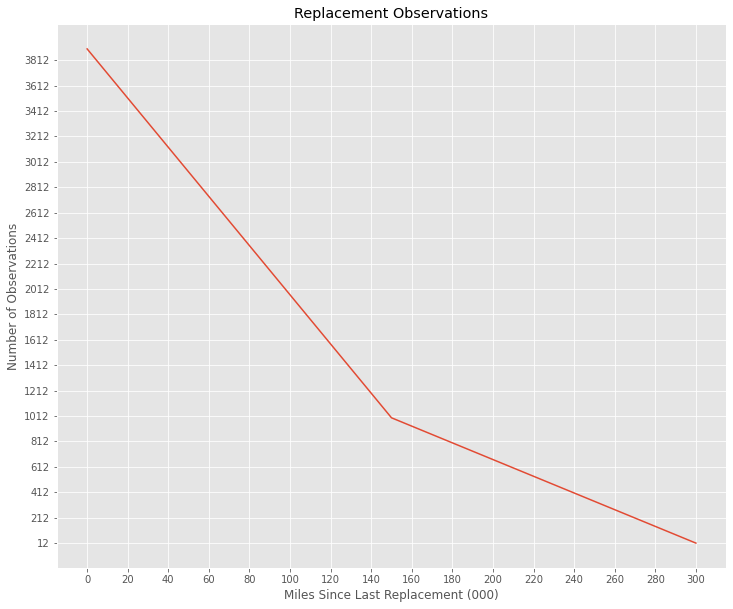

In [7]:
stordat()